In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import zscore
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import imblearn
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
import missingno as msno

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plt.rcParams["figure.figsize"] = [10,5]

##### Since manually shuffling the rows significantly improved the performance of my model, I will do it again to figure out whether or not it will improve everything again. I will take my raw data as my baseline.

## XGBoost and Naive Bayes on data

In [ ]:
df = pd.read_excel('/content/dataset.xlsx')
df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


### Data Cleaning

In [ ]:
df_null_pct = df.isna().mean().round(4) * 100

df_null_pct.sort_values(ascending=False)

Prothrombin time (PT), Activity                          100.0
D-Dimer                                                  100.0
Mycoplasma pneumoniae                                    100.0
Urine - Sugar                                            100.0
Partial thromboplastin time (PTT)                        100.0
                                                         ...  
Patient addmited to semi-intensive unit (1=yes, 0=no)      0.0
Patient addmited to regular ward (1=yes, 0=no)             0.0
SARS-Cov-2 exam result                                     0.0
Patient age quantile                                       0.0
Patient ID                                                 0.0
Length: 111, dtype: float64

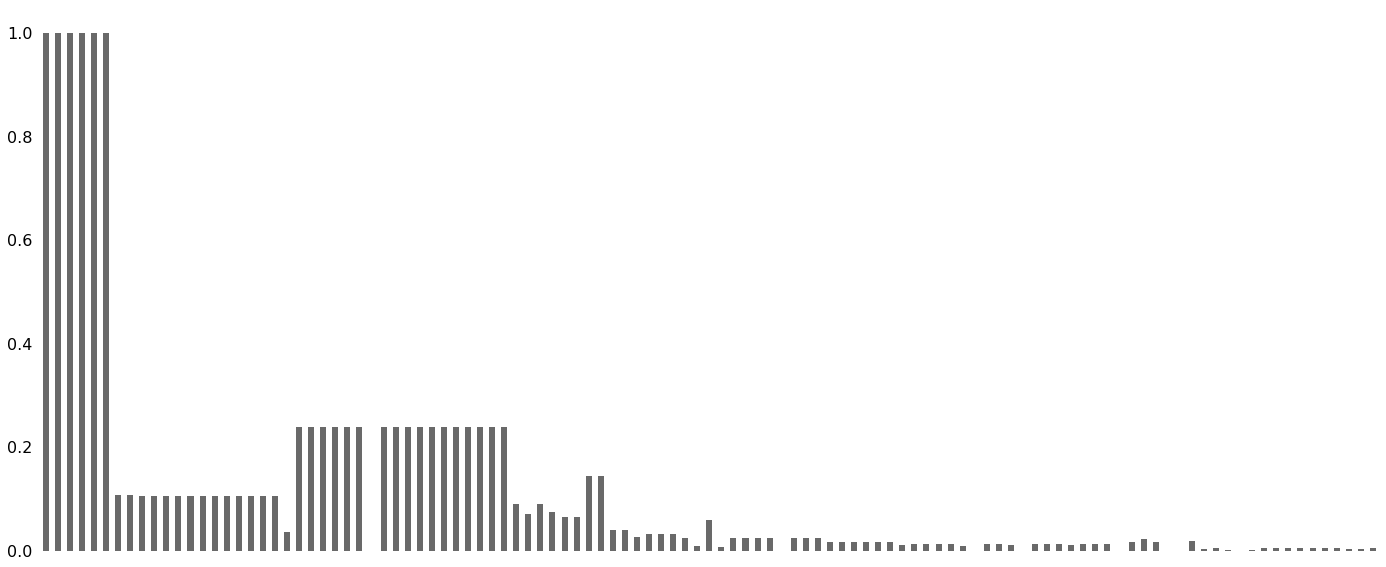

In [ ]:
msno.bar(df)

In [ ]:
print(df.isnull)

<bound method DataFrame.isnull of            Patient ID  ...  ctO2 (arterial blood gas analysis)
0     44477f75e8169d2  ...                                 NaN
1     126e9dd13932f68  ...                                 NaN
2     a46b4402a0e5696  ...                                 NaN
3     f7d619a94f97c45  ...                                 NaN
4     d9e41465789c2b5  ...                                 NaN
...               ...  ...                                 ...
5639  ae66feb9e4dc3a0  ...                                 NaN
5640  517c2834024f3ea  ...                                 NaN
5641  5c57d6037fe266d  ...                                 NaN
5642  c20c44766f28291  ...                                 NaN
5643  2697fdccbfeb7f7  ...                                 NaN

[5644 rows x 111 columns]>


In [ ]:
columns = ['Patient age quantile', 'SARS-Cov-2 exam result','Patient addmited to regular ward (1=yes, 0=no)',
           'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)',
           'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes',
           'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)',
           'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 
           'CoronavirusNL63', 'Rhinovirus/Enterovirus','Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43' ,
           'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2']

In [ ]:
df=df[columns]

In [ ]:
df_new = df.dropna(subset=['Hematocrit'])
df_new = df_new.fillna(-9)

In [ ]:
from sklearn.preprocessing import LabelEncoder
for col in df_new.columns:
  if df_new[col].dtype=='object':
    lbl = LabelEncoder()
    lbl.fit(list(df_new[col].values))
    df_new[col] = lbl.transform(list(df_new[col].values))

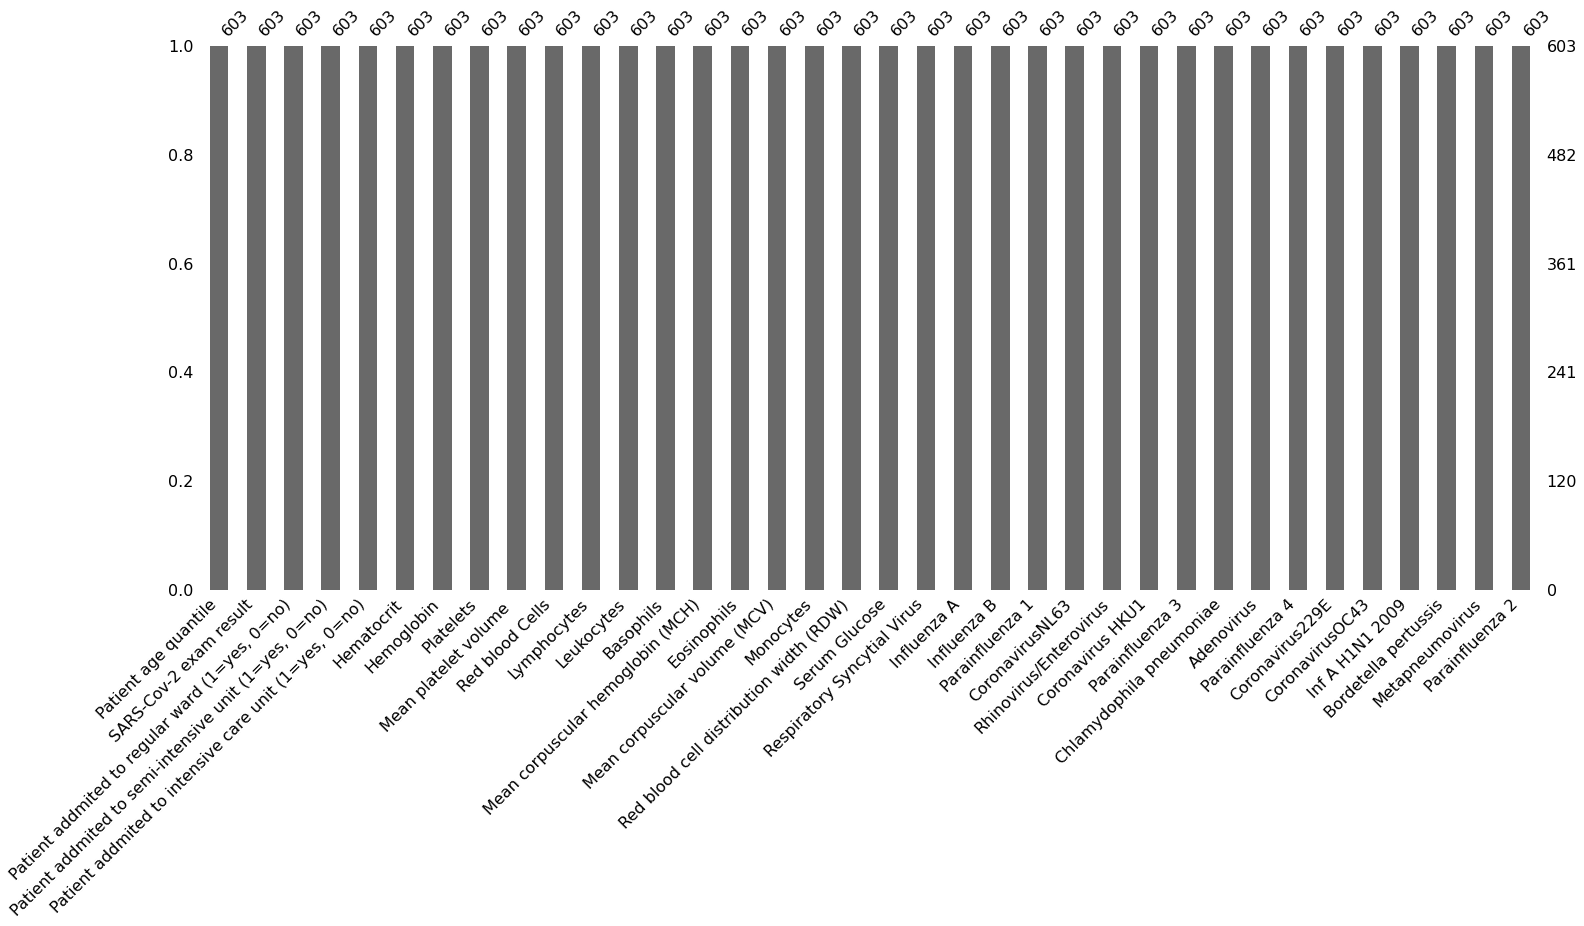

In [ ]:
msno.bar(df_new)

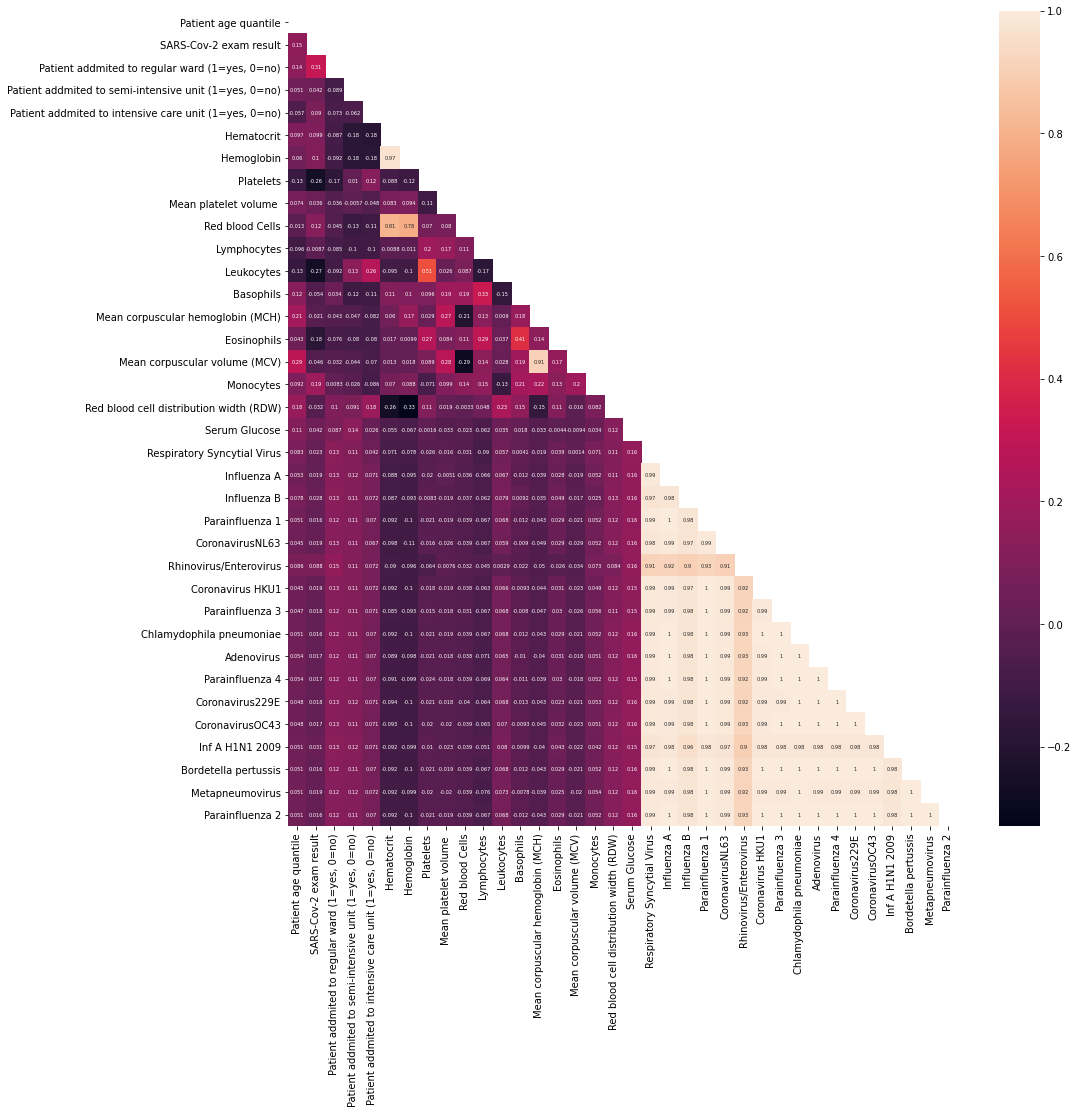

In [ ]:
matrix = np.triu(df_new.corr())
plt.figure(figsize=(15,15))
sns.heatmap(df_new.corr(), mask=matrix, annot=True, annot_kws={'size': 5})

In [ ]:
# renaming the target column
df_new = df_new.rename({"SARS-Cov-2 exam result":"result"}, axis='columns')
  
df_new

,Patient age quantile,result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
1,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,2,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,1
8,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,0.364550,-0.223767,0.178175,1.018625,-1.336024,0.068652,-0.978899,-0.413208,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
15,9,0,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,-0.884923,0.081693,1.746323,-0.666950,1.668409,1.276759,-1.067355,-9.000000,2,2,2,1,2,2,2,2,1,2,2,2,2,1,1,2,1
18,11,0,0,0,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.211488,-0.834685,0.334989,-0.709090,0.606842,-0.220244,0.171035,-9.000000,2,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,1
22,9,0,0,0,0,0.190738,-0.147652,-0.668155,1.020415,-0.127191,0.002791,-1.132592,0.387152,-0.083183,-0.709090,0.566783,2.012129,0.613318,-0.837191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,19,0,0,0,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.328365,-0.834685,-0.449085,0.892207,-0.474754,1.066653,0.347948,2.433532,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
5614,19,0,0,0,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,1.569499,0.081693,-2.174047,-0.540532,-1.976971,1.670707,0.967144,0.253050,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
5615,15,0,0,0,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,-0.550988,-0.223767,0.700891,-0.709090,0.005955,0.909074,-1.155812,-9.000000,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
5618,17,0,0,0,0,-3.242548,-2.779203,-1.773594,-0.550290,-3.318285,-1.830953,-1.733675,-1.140144,2.059952,-0.582671,1.408024,1.381812,-0.448160,0.041059,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1


In [ ]:
df_new["result"]

1       0
8       0
15      0
18      0
22      0
       ..
5602    0
5614    0
5615    0
5618    0
5643    1
Name: result, Length: 603, dtype: int64

In [ ]:
aggr = df_new.groupby('result').agg(['mean', 'std'])
aggr

Patient age quantile            ... Parainfluenza 2          
                       mean       std  ...            mean       std
result                                 ...                          
0                 10.792308  5.806376  ...        0.603846  0.489568
1                 13.325301  4.588183  ...        0.626506  0.486672

[2 rows x 70 columns]

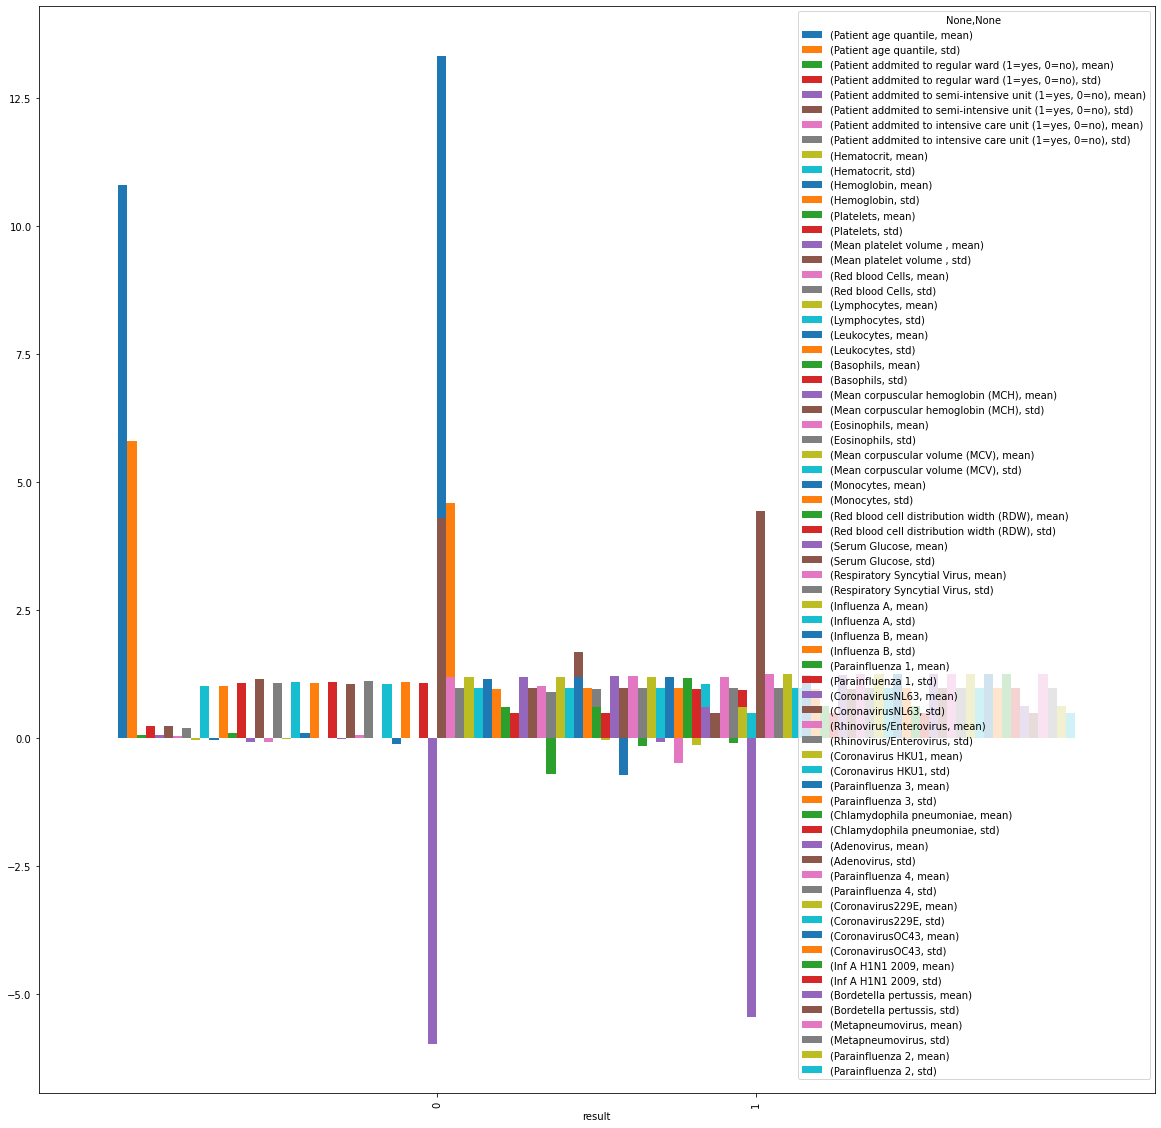

In [ ]:
aggr.plot.bar(figsize=(20,20),width=2)

In [ ]:
X = df_new[['Patient age quantile', 'Patient addmited to regular ward (1=yes, 0=no)',
           'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)',
           'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes',
           'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)',
           'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 
           'CoronavirusNL63', 'Rhinovirus/Enterovirus','Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43' ,
           'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2']]
y= df_new['result']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr=LogisticRegression()
lr.fit(X_train,y_train)
pred_test=lr.predict(X_test)
pred_train= lr.predict(X_train)

acc_train_lr= accuracy_score(y_train,pred_train)
acc_test_lr = accuracy_score(y_test,pred_test)

In [ ]:
print("logistic regression: Accuracy on training Data: {:.3f}".format(acc_train_lr))
print("logistic regression: Accuracy on test Data: {:.3f}".format(acc_test_lr))

logistic regression: Accuracy on training Data: 0.925
logistic regression: Accuracy on test Data: 0.901


### Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
lin_svc=SVC()
lin_svc.fit(X_train,y_train)
prediction_test=lin_svc.predict(X_test)
prediction_train=lin_svc.predict(X_train)
acc_train_svc = accuracy_score(y_train,prediction_train)
acc_test_svc = accuracy_score(y_test,prediction_test)


In [ ]:
print("SVC: Accuracy on training Data: {:.3f}".format(acc_train_svc))
print("SVC: Accuracy on test Data: {:.3f}".format(acc_test_svc))

SVC: Accuracy on training Data: 0.867
SVC: Accuracy on test Data: 0.848


### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
predict_test= dt.predict(X_test)
predict_train= dt.predict(X_train)
acc_train_tree = accuracy_score(y_train,predict_train)
acc_test_tree = accuracy_score(y_test,predict_test)

In [ ]:
print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))

Decision Tree: Accuracy on training Data: 1.000
Decision Tree: Accuracy on test Data: 0.848


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
rfc= rfc.fit(X_train,y_train)
prediction_train = rfc.predict(X_train )
prediction_test = rfc.predict(X_test)
acc_train_rf = accuracy_score(y_train,prediction_train)
acc_test_rf = accuracy_score(y_test,prediction_test)


In [ ]:
print("Randomforest: Accuracy on training Data: {:.3f}".format(acc_train_rf))
print("Randomforest: Accuracy on test Data: {:.3f}".format(acc_test_rf))

Randomforest: Accuracy on training Data: 1.000
Randomforest: Accuracy on test Data: 0.868


### XG-Boost 

In [ ]:
clf = XGBClassifier()
clf.fit(X, y)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 98.23%
Validation accuracy: 97.35%


In [ ]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       128
           1       1.00      0.83      0.90        23

    accuracy                           0.97       151
   macro avg       0.98      0.91      0.94       151
weighted avg       0.97      0.97      0.97       151



In [ ]:

print(metrics.confusion_matrix(y_test, test_preds))


[[128   0]
 [  4  19]]


### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train, y_train)
naive_predict_test=gnb.predict(X_test)
naive_predict_train=gnb.predict(X_train)
acc_train_G= accuracy_score(y_train,naive_predict_train)
acc_test_G = accuracy_score(y_test,naive_predict_test)


In [ ]:
print("GaussianNB: Accuracy on training Data: {:.3f}".format(acc_train_G))
print("GaussianNB: Accuracy on test Data: {:.3f}".format(acc_test_G))

GaussianNB: Accuracy on training Data: 0.865
GaussianNB: Accuracy on test Data: 0.881


In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 151 points : 18


##### Bad model! Just assumes that everything is 0, ignoring the underrepresented class.

## Shuffling

In [ ]:
#split original data into two parts: Positive and Negative
df_negative = df_new[df_new['result'] == 0]
df_positive = df_new[df_new['result'] == 1]

In [ ]:
df_negative.shape

(520, 36)

In [ ]:
df_positive.shape

(83, 36)

In [ ]:
#shuffle the rows of the Negative df
df_negative = shuffle(df_negative)

In [ ]:
#crop the negatives df so it matches the shape of the positive df
df_negative_83=df_negative[:83]

In [ ]:
df_negative_83.shape

(83, 36)

In [ ]:
df_positive.shape

(83, 36)

In [ ]:
#put two df together so we get a df of two equally represented classes
twodf = [df_positive, df_negative_83]
edf = pd.concat(twodf, ignore_index=True)

#shuffle them again!
edf = shuffle(edf)
edf.head()

,Patient age quantile,result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
86,10,0,0,0,0,0.991838,0.666876,-0.454604,-0.213711,0.860109,-0.952462,0.247673,0.692611,-0.449085,-0.456253,-0.014074,-0.798034,-0.713529,-9.000000,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
69,19,1,0,0,0,-0.244145,-1.087492,-1.045009,-9.000000,2.975753,-0.210435,-1.207727,0.387152,-5.519430,-0.245556,-4.941344,2.353550,3.001642,0.889024,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
124,0,0,0,0,1,-2.418559,-2.152643,0.952319,-1.672222,-1.237902,-1.694489,4.224283,-1.140144,-1.808146,-0.835508,-2.297444,-1.533404,0.436405,0.192481,2,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,1
82,19,1,0,0,0,0.694287,0.541564,-0.906829,-0.325903,0.578024,-0.295726,-1.288428,-1.140144,-0.135455,-0.835508,0.025985,0.567652,-0.182790,-9.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,18,0,0,0,0,0.946061,0.854844,-0.718402,0.908221,0.366460,0.540121,-1.032411,0.387152,0.753163,0.260116,0.907285,0.016125,-0.359703,-9.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
edf.result.value_counts()
#see, equally represented

1    83
0    83
Name: result, dtype: int64

In [ ]:
edf.shape

(166, 36)

In [ ]:
#see how the classes are different in terms of varience and central tendency
aggs = edf.groupby('result').agg(['mean', 'std'])
aggs

Patient age quantile            ... Parainfluenza 2          
                       mean       std  ...            mean       std
result                                 ...                          
0                 10.783133  5.944968  ...        0.734940  0.444048
1                 13.325301  4.588183  ...        0.626506  0.486672

[2 rows x 70 columns]

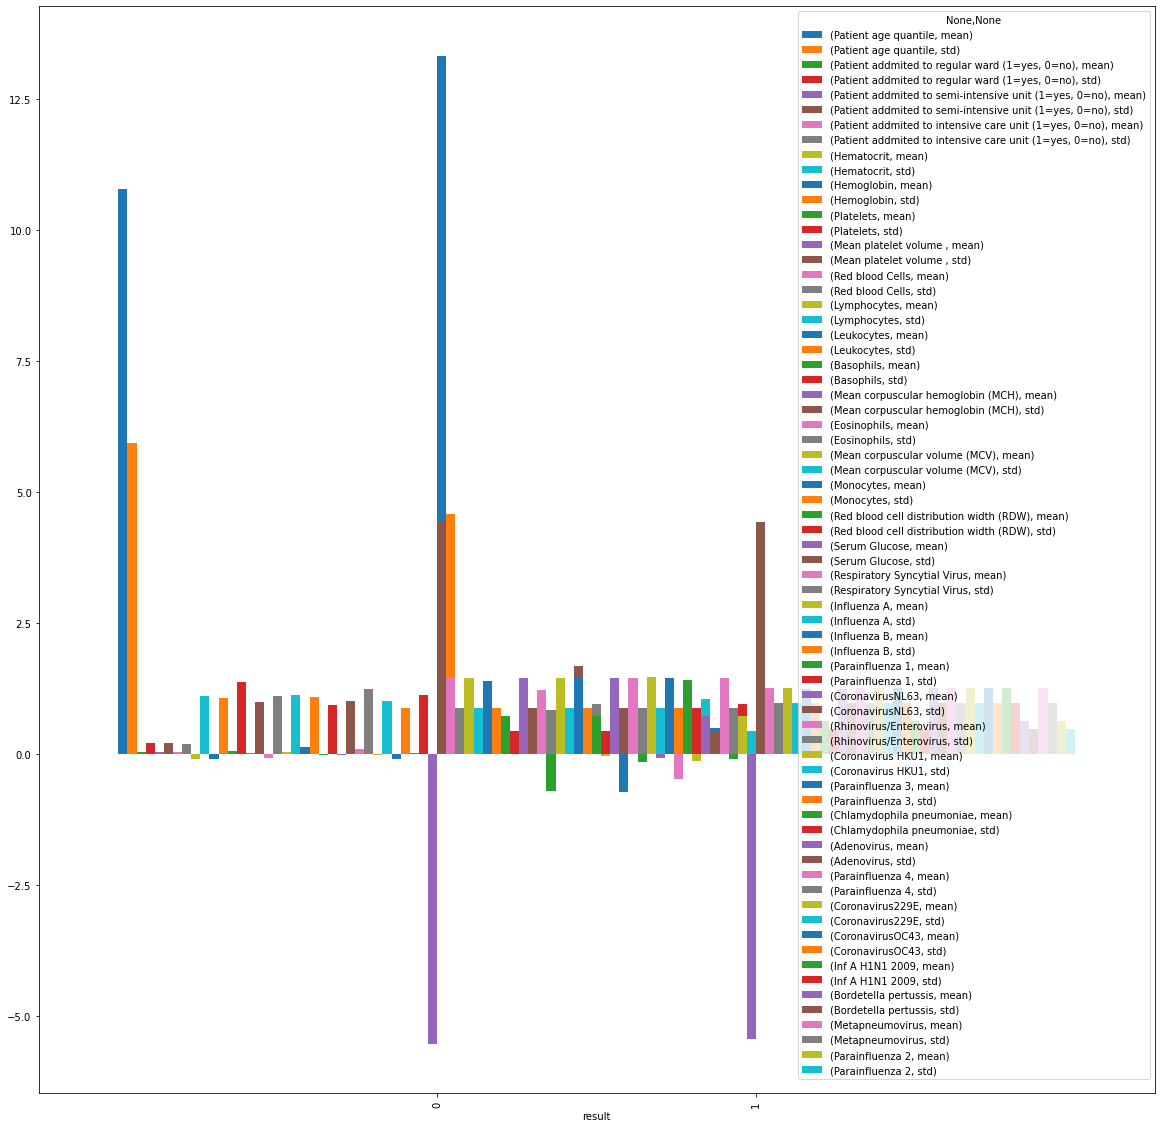

In [ ]:
aggs.plot.bar(figsize=(20,20),width=2)

### Try all the above algorithms again!!!

In [ ]:
Xsh = edf[['Patient age quantile', 'Patient addmited to regular ward (1=yes, 0=no)',
           'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)',
           'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes',
           'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)',
           'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 
           'CoronavirusNL63', 'Rhinovirus/Enterovirus','Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43' ,
           'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2']]
ysh= edf['result']

In [ ]:
Xsh_train, Xsh_test, ysh_train, ysh_test = train_test_split(Xsh, ysh, test_size=0.2, random_state=100)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr=LogisticRegression()
lr.fit(Xsh_train,ysh_train)
pred_test=lr.predict(Xsh_test)
pred_train= lr.predict(Xsh_train)

acc_train_lrs= accuracy_score(ysh_train,pred_train)
acc_test_lrs = accuracy_score(ysh_test,pred_test)

In [ ]:
print("logistic regression: Accuracy on training Data: {:.3f}".format(acc_train_lrs))
print("logistic regression: Accuracy on test Data: {:.3f}".format(acc_test_lrs))

logistic regression: Accuracy on training Data: 0.879
logistic regression: Accuracy on test Data: 0.735


### SVC 

In [ ]:
from sklearn.svm import SVC
lin_svc=SVC()
lin_svc.fit(Xsh_train,ysh_train)
prediction_test=lin_svc.predict(Xsh_test)
prediction_train=lin_svc.predict(Xsh_train)
acc_train_svcs = accuracy_score(ysh_train,prediction_train)
acc_test_svcs = accuracy_score(ysh_test,prediction_test)

In [ ]:
print("SVC: Accuracy on training Data: {:.3f}".format(acc_train_svcs))
print("SVC: Accuracy on test Data: {:.3f}".format(acc_test_svcs))

SVC: Accuracy on training Data: 0.750
SVC: Accuracy on test Data: 0.588


### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(Xsh_train, ysh_train)
naive_predict_test=gnb.predict(Xsh_test)
naive_predict_train=gnb.predict(Xsh_train)
acc_train_Gs= accuracy_score(ysh_train,naive_predict_train)
acc_test_Gs = accuracy_score(ysh_test,naive_predict_test)

In [ ]:
print("GaussianNB: Accuracy on training Data: {:.3f}".format(acc_train_Gs))
print("GaussianNB: Accuracy on test Data: {:.3f}".format(acc_test_Gs))

GaussianNB: Accuracy on training Data: 0.750
GaussianNB: Accuracy on test Data: 0.794


In [ ]:
gnb = GaussianNB()
ysh_pred = gnb.fit(Xsh_train, ysh_train).predict(Xsh_test)
print("Number of mislabeled points out of a total %d points : %d" 
      % (Xsh_test.shape[0], (ysh_test != ysh_pred).sum()))

Number of mislabeled points out of a total 34 points : 7


##### Unfortunateltly, Naive Bayes is not a good fit for my data.

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt=DecisionTreeClassifier()
dt=dt.fit(Xsh_train,ysh_train)
predict_test= dt.predict(Xsh_test)
predict_train= dt.predict(Xsh_train)
acc_train_tree_sh = accuracy_score(ysh_train,predict_train)
acc_test_tree_sh = accuracy_score(ysh_test,predict_test)

In [ ]:
print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree_sh))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree_sh))

Decision Tree: Accuracy on training Data: 1.000
Decision Tree: Accuracy on test Data: 0.794


### Random Forest Classifer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
rfc= rfc.fit(Xsh_train,ysh_train)
prediction_train = rfc.predict(Xsh_train )
prediction_test = rfc.predict(Xsh_test)
acc_train_rfs = accuracy_score(ysh_train,prediction_train)
acc_test_rfs = accuracy_score(ysh_test,prediction_test)

In [ ]:
print("Randomforest: Accuracy on training Data: {:.3f}".format(acc_train_rfs))
print("Randomforest: Accuracy on test Data: {:.3f}".format(acc_test_rfs))

Randomforest: Accuracy on training Data: 1.000
Randomforest: Accuracy on test Data: 0.853


### XG-Boost Classifier

In [ ]:

clf = XGBClassifier()
clf.fit(Xsh, ysh)

training_preds_ = clf.predict(Xsh_train)
test_preds_ = clf.predict(Xsh_test)

training_accuracy_ = accuracy_score(ysh_train, training_preds_)
test_accuracy_ = accuracy_score(ysh_test, test_preds_)

print('Training Accuracy: {:.4}%'.format(training_accuracy_ * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy_ * 100))
print(classification_report(ysh_test, test_preds_))
print(metrics.confusion_matrix(ysh_test, test_preds_))

Training Accuracy: 100.0%
Validation accuracy: 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        17

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

[[17  0]
 [ 0 17]]


In [ ]:

dii = {'Training Accuracy Score': '100.0%',
      'Validation Accuracy Score': '100.0%',
      'Precision, non-winners': '1.00',
      'Precision, winners': '1.0',
      'Recall, non-winners': '1.0',
      'Recall, winners': '1.0',
      'F1': '1.0',}
diif = pd.DataFrame.from_dict(dii, orient='index')
diif

,0
Training Accuracy Score,100.0%
Validation Accuracy Score,100.0%
"Precision, non-winners",1.00
"Precision, winners",1.0
"Recall, non-winners",1.0
"Recall, winners",1.0
F1,1.0


## Comparsion of Models

In [ ]:
import pandas as pd

data = {'ML Model':['XGBoost', 'Logistic Regression','Random Forest', 'SVM','Gaussian_ Naive Bayes','Decision Tree'],
		'Train Accuracy':[98.23,93.4,100,86.7,82.3,100],
    'Test Accuracy':[97.35,88.7,88.1,84.8,82.1,80.8]}


df = pd.DataFrame(data)

df


,ML Model,Train Accuracy,Test Accuracy
0,XGBoost,98.23,97.35
1,Logistic Regression,93.40,88.70
2,Random Forest,100.00,88.10
3,SVM,86.70,84.80
4,Gaussian_ Naive Bayes,82.30,82.10
5,Decision Tree,100.00,80.80


## ML Models after Shuffling and Undersampling

In [ ]:
import pandas as pd

data = {'ML Model':['XGBoost','Random Forest','Logistic Regression','Decision Tree' ,'SVM','Gaussian_ Naive Bayes'],
		'Train Accuracy':[100,100,88.6,100,82.6,83.3],
    'Test Accuracy':[100,85.3,79.4,76.5,76.5,73.5]}


dfs= pd.DataFrame(data)

dfs

,ML Model,Train Accuracy,Test Accuracy
0,XGBoost,100.0,100.0
1,Random Forest,100.0,85.3
2,Logistic Regression,88.6,79.4
3,Decision Tree,100.0,76.5
4,SVM,82.6,76.5
5,Gaussian_ Naive Bayes,83.3,73.5


## Visualizations of equal data

Target Variable
result
0    83
1    83
Name: result, dtype: int64


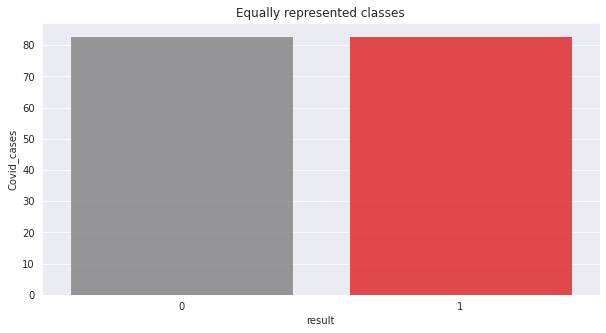

In [ ]:

print('Target Variable')
print(edf.groupby(['result']).result.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(edf['result'], alpha =.80, palette= ['grey','red'])
plt.title('Equally represented classes')
plt.ylabel('Covid_cases')
plt.show()

## Do it AGAIN

In [ ]:
df_new.head()

,Patient age quantile,result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
1,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,2,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,1
8,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,0.364550,-0.223767,0.178175,1.018625,-1.336024,0.068652,-0.978899,-0.413208,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
15,9,0,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,-0.884923,0.081693,1.746323,-0.666950,1.668409,1.276759,-1.067355,-9.000000,2,2,2,1,2,2,2,2,1,2,2,2,2,1,1,2,1
18,11,0,0,0,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.211488,-0.834685,0.334989,-0.709090,0.606842,-0.220244,0.171035,-9.000000,2,2,2,1,2,1,2,2,1,2,2,2,2,2,1,2,1
22,9,0,0,0,0,0.190738,-0.147652,-0.668155,1.020415,-0.127191,0.002791,-1.132592,0.387152,-0.083183,-0.709090,0.566783,2.012129,0.613318,-0.837191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_n = df_new[df_new['result'] == 0]
df_p = df_new[df_new['result'] == 1] 

In [ ]:
df_ns = shuffle(df_n)

In [ ]:
df_n_83 = df_n[:83]

In [ ]:
twodf = [df_p, df_n_83]
eqdfs = pd.concat(twodf, ignore_index=True)

#shuffle them again!
eqdfs = shuffle(eqdfs)
eqdfs.head()

,Patient age quantile,result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
123,5,0,0,0,0,2.090489,2.045308,-0.768649,1.469188,1.935561,-0.236022,-0.211488,0.081693,-0.030911,-0.245556,-0.174311,2.248498,0.436405,-9.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,15,1,1,0,0,-0.404364,-0.586244,-2.062515,-9.000000,2.922861,-0.500423,-1.463744,0.081693,-4.839900,-0.835508,-5.101581,-0.692982,4.947686,-9.000000,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
54,19,1,0,1,0,-0.473031,-0.648900,-0.165682,0.235063,-0.691362,0.053965,-0.645603,2.219906,0.125903,-0.624811,0.566783,0.961600,2.382447,0.041059,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1
110,18,0,0,0,0,0.946061,0.854844,-0.718402,0.908221,0.366460,0.540121,-1.032411,0.387152,0.753163,0.260116,0.907285,0.016125,-0.359703,-9.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76,19,1,1,0,0,-0.793470,-0.774212,-0.316424,1.020415,-0.638471,0.582766,-1.004583,-0.529226,-0.239998,-0.835508,-0.214369,1.381812,-0.005877,-9.000000,2,2,2,1,2,2,2,2,1,2,2,2,2,2,1,2,1


In [ ]:
Xs = eqdfs[['Patient age quantile', 'Patient addmited to regular ward (1=yes, 0=no)',
           'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)',
           'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes',
           'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)',
           'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 
           'CoronavirusNL63', 'Rhinovirus/Enterovirus','Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43' ,
           'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2']]
ys= eqdfs['result']

In [ ]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.3, random_state=100)

In [ ]:

clf = XGBClassifier()
clf.fit(Xs, ys)

training_preds__ = clf.predict(Xs_train)
test_preds__ = clf.predict(Xs_test)

training_accuracy__ = accuracy_score(ys_train, training_preds__)
test_accuracy__ = accuracy_score(ys_test, test_preds__)

print('Training Accuracy: {:.4}%'.format(training_accuracy__ * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy__ * 100))
print(classification_report(ys_test, test_preds__))
print(metrics.confusion_matrix(ys_test, test_preds__))
print(metrics.f1_score(ys_test, test_preds__))
print(metrics.recall_score(ys_test, test_preds__))

Training Accuracy: 100.0%
Validation accuracy: 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        30

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

[[20  0]
 [ 0 30]]
1.0
1.0
